<a href="https://colab.research.google.com/github/neriiacopo/IAAC-II-CLIPStudies-Masterclass/blob/main/IAACII_CLIP_Studies_ZeroShot_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *CLIP Studies @ ETSAM - November 2024*
#**HOW - Zero Shot Classification with CLIP**
*Iacopo Neri (iacopo.neri@uzh.ch) -- IAAC Faculty & MaCT Computational Lead (Spain) // Digital Visual Studies, University of Zurich (Switzerland)*

*Darìo Negueruela del Castillo (iacopo.neri@uzh.ch) -- Digital Visual Studies, University of Zurich (Switzerland)*

The following script takes extensive inspiration from the original [Language-Visual Saliency with CLIP and OpenVINO™](https://docs.openvino.ai/2023.2/notebooks/232-clip-language-saliency-map-with-output.html)

# Import libraries

In [8]:
! pip install open_clip_torch matplotlib -q

In [9]:
import numpy as np
import torch
import os
import open_clip
from open_clip import tokenizer

import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import requests

from collections import OrderedDict

import requests
from io import BytesIO

# Import Model

In [10]:
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

# General functions

In [11]:
def read_images(dir:str):
    original_images=[]
    images=[]

    for filename in [filename for filename in os.listdir(dir) if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg")]:
        image = Image.open(os.path.join(dir, filename)).convert("RGB")

        original_images.append(image)
        images.append(preprocess(image))

    return original_images, images

def read_url(url=""):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    original_images=[image]
    images=[preprocess(image)]

    return original_images, images


def embed(images:list[np.array], text_descriptions:list[str]) -> None:
    image_input = torch.tensor(np.stack(images))
    text_tokens = tokenizer.tokenize(text_descriptions)

    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    return image_features, text_features


def run_cosine_similarity(images:list[np.array], text_descriptions:list[str]) -> None:
    image_features, text_features = embed(images=images, text_descriptions=text_descriptions)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    return similarity


def run_classification(images:list[np.array], text_descriptions:list[str], top_results=5) -> None:
    image_features, text_features = embed(images=images, text_descriptions=text_descriptions)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(top_results, dim=-1)

    return top_probs, top_labels


def draw_matrix(original_images:list[np.array], descriptions:list[str], similarity):
    count = len(descriptions)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), descriptions, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title("Cosine similarity between text and image features", size=20)


def draw_chart(original_images:list[np.array], descriptions:list[str], top_probs, top_labels):
    plt.figure(figsize=(16, 16))

    for i, image in enumerate(original_images):
        plt.subplot(4, 4, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(4, 4, 2 * i + 2)
        y = np.arange(top_probs.shape[-1])
        plt.grid()
        plt.barh(y, top_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        plt.yticks(y, [descriptions[index] for index in top_labels[i].numpy()])
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

# Run Similarity Matrix

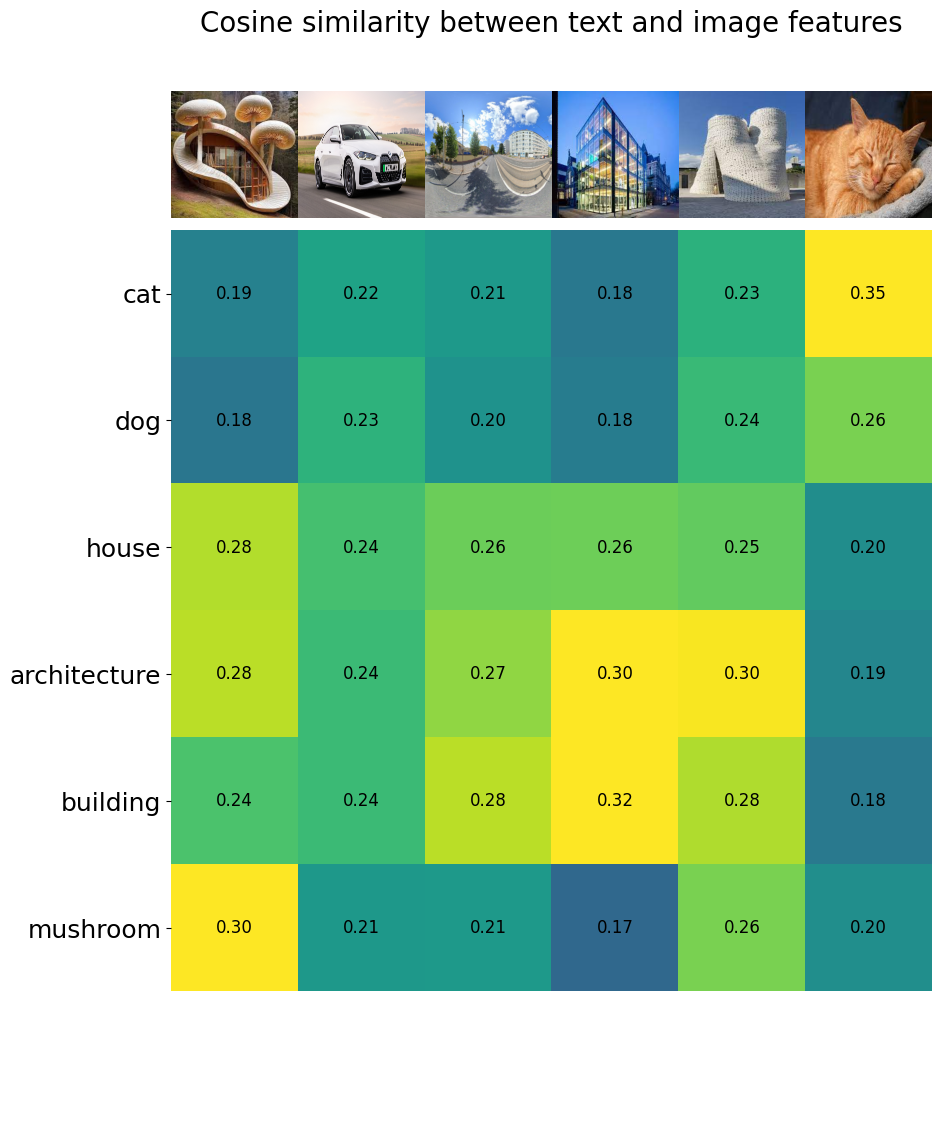

In [14]:
#@title Settings 🔬🎨

#@markdown _place the images in a new folder and provide its name in the following_:
dir = "images" #@param {type:"string"}

# Prepare the text queries
#@markdown _in the form pre_prompt {label}_:
pre_prompt = "This is a " #@param {type:"string"}

#@markdown _to separate labels use_ ;
labels = "cat;dog;house;architecture;building;mushroom" #@param {type:"string"}

# Import data
original_images, images = read_images(dir=dir)

# Preprocess inputs
labels = labels.split(";")
pre_prompt = "an image of a "
text_descriptions = [f"{pre_prompt} {label}" for label in labels]

# Evaluate similarity
similarity = run_cosine_similarity(images=images, text_descriptions=text_descriptions)

# Plot result
draw_matrix(original_images=original_images, descriptions=labels, similarity=similarity)

# Run Classification

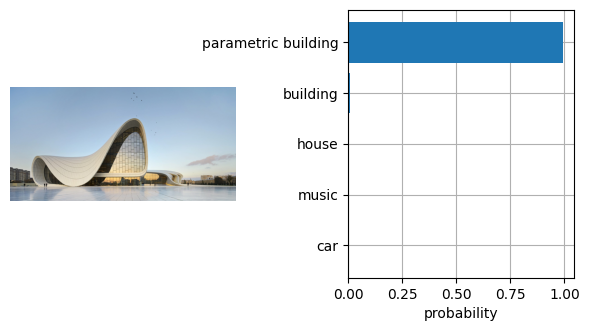

In [19]:
#@title Settings 🔬🎨
url = "https://miro.medium.com/v2/resize:fit:4000/1*3CJowVBtXxqXOuQ7_b-qSA.jpeg" #@param {type:"string"}

# Prepare the text queries
#@markdown _in the form pre_prompt {label}_:
pre_prompt = "A photo of a " #@param {type:"string"}

#@markdown _to separate labels use_ ;
labels = "cat;car;house;person;glass of wine;hammer;doll;music;building;mushroom;parametric building" #@param {type:"string"}
top_results = 5 #@param {type:"number"}

# Import data
original_images, images = read_url(url=url)

# Preprocess inputs
labels = labels.split(";")
pre_prompt = "an image of a "
text_descriptions = [f"{pre_prompt} {label}" for label in labels]

# Evaluate similarity
top_probs, top_labels = run_classification(images=images, text_descriptions=text_descriptions, top_results=top_results)

# Plot result
draw_chart(original_images=original_images, descriptions=labels, top_probs=top_probs, top_labels=top_labels)